In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/AFCS

Mounted at /content/drive
/content/drive/MyDrive/AFCS


In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.statespace import exponential_smoothing
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.api import STLForecast

In [5]:
calendar = pd.read_csv("calendar_afcs2023.csv")
sell_prices = pd.read_csv("sell_prices_afcs2023.csv")
sales_train = pd.read_csv("sales_train_validation_afcs2023.csv")
sales_test = pd.read_csv("sales_test_validation_afcs2022.csv") # only use for testing
sample_submission = pd.read_csv("sample_submission_afcs2023.csv")

In [7]:
sales_train

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_3_001_TX_3_validation,0,2,1,3,0,0,1,0,2,...,0,0,0,0,2,0,0,5,2,0
1,FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
3,FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,FOODS_3_005_TX_3_validation,0,1,1,0,0,1,2,0,0,...,0,4,2,1,1,0,1,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,FOODS_3_823_TX_3_validation,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,2,0,2
819,FOODS_3_824_TX_3_validation,0,1,0,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
820,FOODS_3_825_TX_3_validation,0,0,0,2,1,1,0,0,1,...,1,1,1,3,1,0,0,4,2,0
821,FOODS_3_826_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,2,1,1,5,3,1,2,1,2


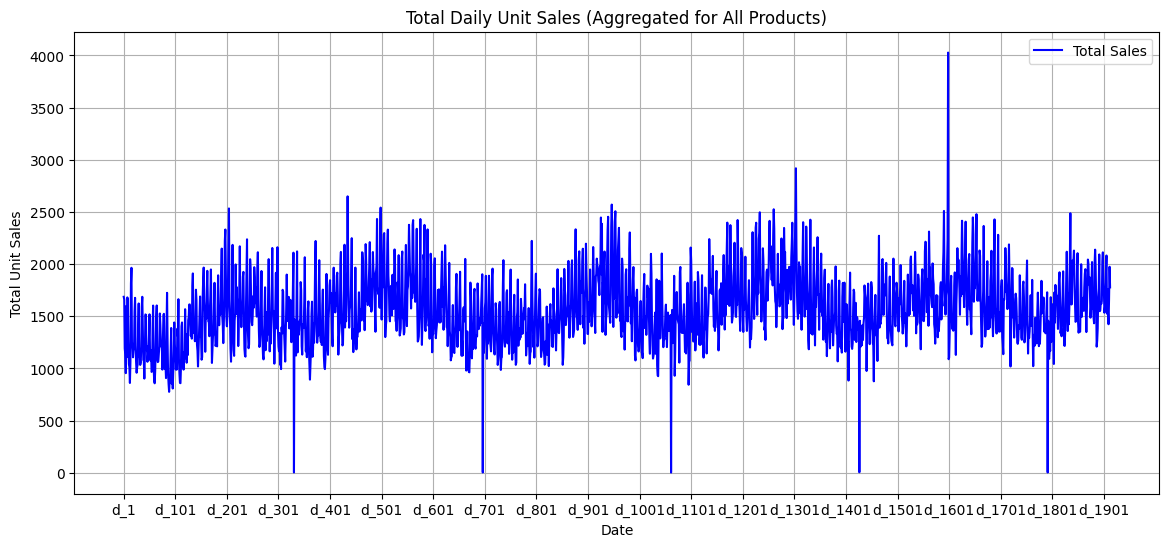

In [8]:
total_sales = sales_train.iloc[:, 1:].sum(axis=0)

plt.figure(figsize=(14, 6))
plt.plot(total_sales.index, total_sales.values, label='Total Sales', color='blue')
plt.title('Total Daily Unit Sales (Aggregated for All Products)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 1913, 100))
plt.show()

In [9]:
# Merging the sales train file with the calendar file to better see patterns on actuals dates and be able to see
# sales on day of week and see events.

sales_train_long = pd.melt(sales_train, id_vars=['id'],
                           var_name='day', value_name='sales')
sales_train_long['day'] = pd.to_datetime('2011-01-29') + pd.to_timedelta(sales_train_long['day'].str[2:].astype(int) - 1, unit='D')
calendar['date'] = pd.to_datetime(calendar['date'])

merged_data = pd.merge(sales_train_long, calendar, left_on='day', right_on='date', how='left')

merged_data

,id,day,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,FOODS_3_001_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,FOODS_3_002_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
2,FOODS_3_003_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
3,FOODS_3_004_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
4,FOODS_3_005_TX_3_validation,2011-01-29,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574394,FOODS_3_823_TX_3_validation,2016-04-24,2,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574395,FOODS_3_824_TX_3_validation,2016-04-24,0,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574396,FOODS_3_825_TX_3_validation,2016-04-24,0,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574397,FOODS_3_826_TX_3_validation,2016-04-24,2,2016-04-24,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0


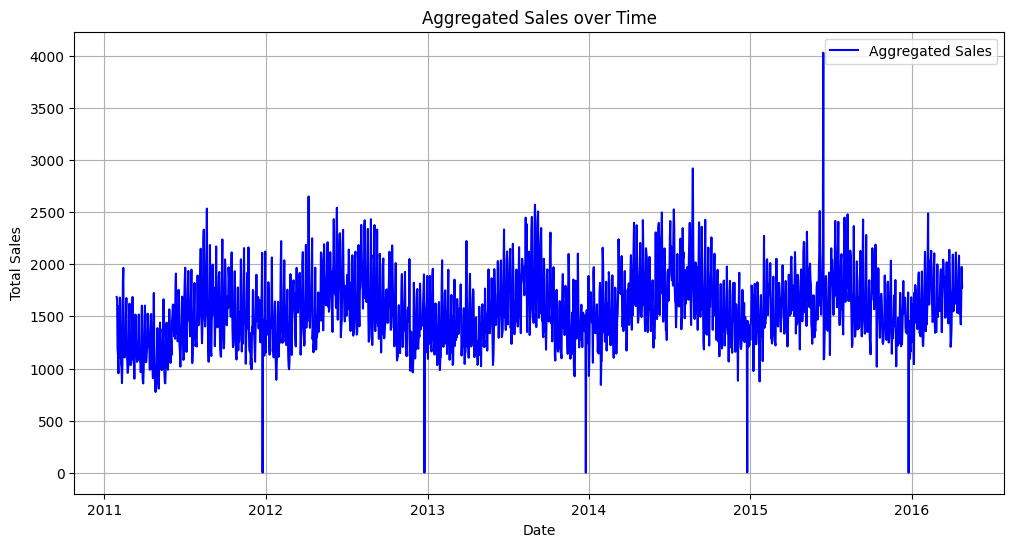

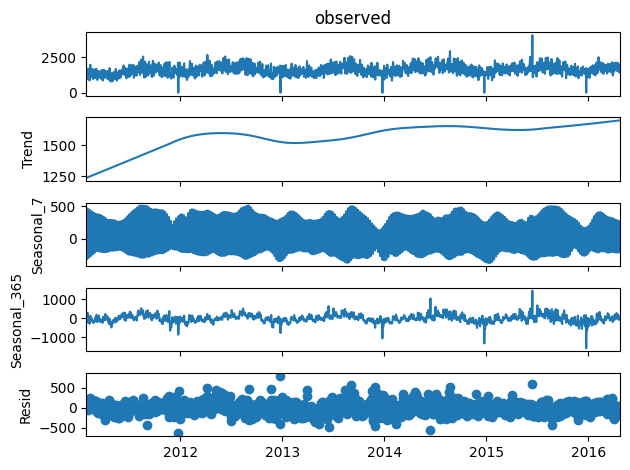

In [31]:
# now we can show sales with actual dates, day of week etc.

daily_sales = merged_data.groupby('day')['sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Aggregated Sales', color='blue')
plt.title('Aggregated Sales over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

# Perform seasonal decomposition for both period 7 and period 365
mstl = MSTL(daily_sales, periods=[7, 365])
res = mstl.fit()
res.seasonal.head()
ax = res.plot()

# Perform seasonal decomposition
#result = seasonal_decompose(daily_sales, model='additive', period=365)

# Plot the decomposed components
#plt.figure(figsize=(12, 8))

#plt.subplot(4, 1, 1)
#plt.plot(daily_sales, label='Original')
#plt.title('Seasonal Decomposition of Aggregated Sales over Time')
#plt.legend(loc='upper left')

#plt.subplot(4, 1, 2)
#plt.plot(result.trend, label='Trend')
#plt.legend(loc='upper left')

#plt.subplot(4, 1, 3)
#plt.plot(result.seasonal, label='Seasonal')
#plt.legend(loc='upper left')

#plt.subplot(4, 1, 4)
#plt.plot(result.resid, label='Residuals')
#plt.legend(loc='upper left')

#plt.tight_layout()
#plt.show()

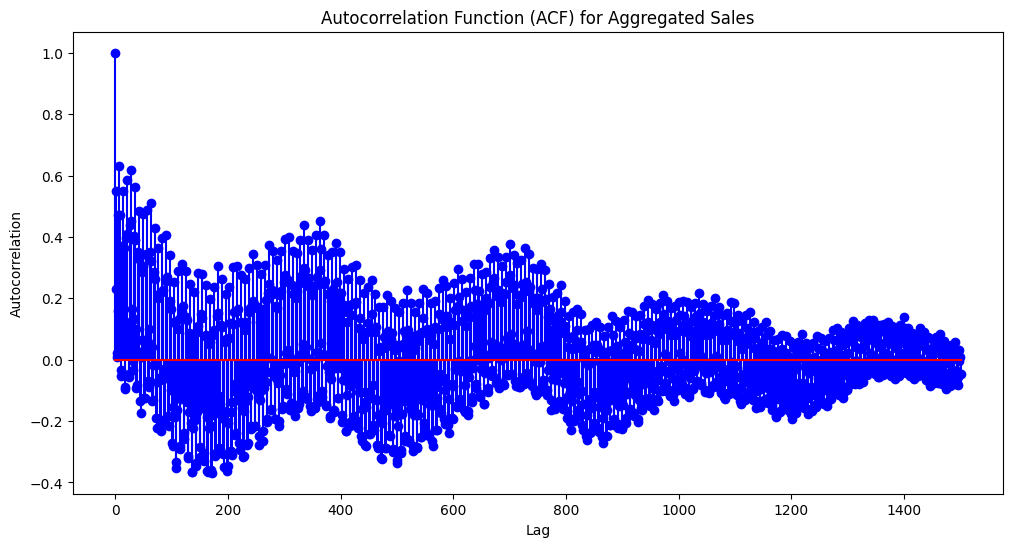

In [11]:
# Calculate the ACF
acf_result = sm.tsa.acf(daily_sales, nlags=1500)

# Plot the ACF
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_result)), acf_result, markerfmt='bo', linefmt='b-', basefmt='r-')
plt.title('Autocorrelation Function (ACF) for Aggregated Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

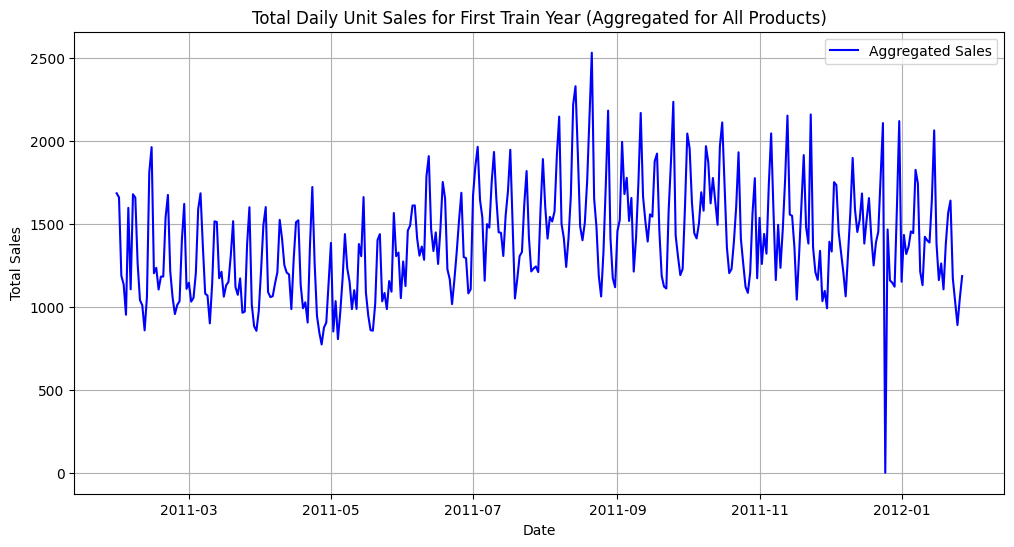

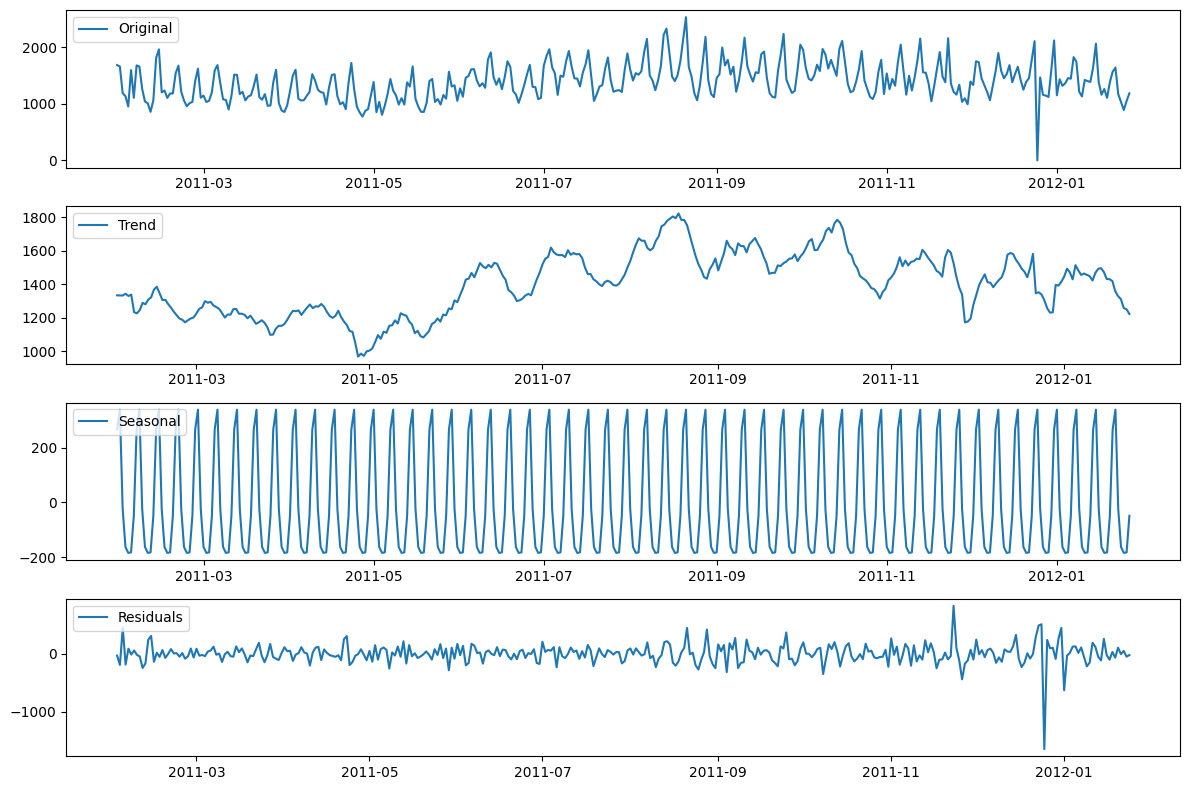

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales[:364].index, daily_sales[:364].values, label='Aggregated Sales', color='blue')
plt.title('Total Daily Unit Sales for First Train Year (Aggregated for All Products)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

# Perform seasonal decomposition
result = seasonal_decompose(daily_sales[:364], model='additive', period=7)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(daily_sales[:364], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Seems like sales are very low on christmas day

print(daily_sales[daily_sales < 10].index)

print(daily_sales[daily_sales > 3000].index)

DatetimeIndex(['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25',
               '2015-12-25'],
              dtype='datetime64[ns]', name='day', freq=None)
DatetimeIndex(['2015-06-15'], dtype='datetime64[ns]', name='day', freq=None)


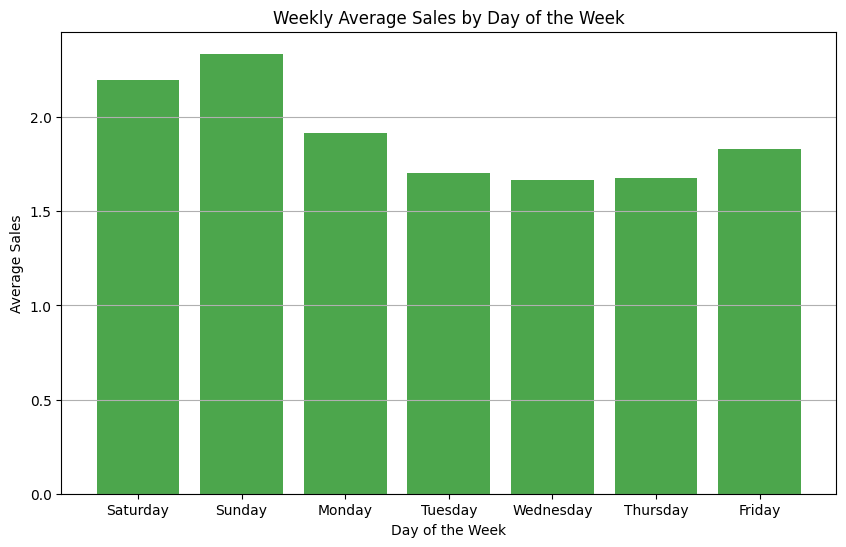

In [14]:
weekly_avg_sales = merged_data.groupby('weekday')['sales'].mean()

# Order days of the week for proper plotting
ordered_days = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekly_avg_sales = weekly_avg_sales.reindex(ordered_days)

plt.figure(figsize=(10, 6))
plt.bar(weekly_avg_sales.index, weekly_avg_sales.values, color='green', alpha=0.7)
plt.title('Weekly Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.grid(axis='y')
plt.show()

In [15]:
unique_events = calendar[['event_name_1', 'event_type_1']].drop_duplicates()
print(unique_events)

            event_name_1 event_type_1
0                    NaN          NaN
8              SuperBowl     Sporting
16         ValentinesDay     Cultural
23         PresidentsDay     National
39             LentStart    Religious
46             LentWeek2    Religious
47         StPatricksDay     Cultural
50             Purim End    Religious
85        OrthodoxEaster    Religious
87            Pesach End    Religious
96         Cinco De Mayo     Cultural
99          Mother's day     Cultural
121          MemorialDay     National
122       NBAFinalsStart     Sporting
134         NBAFinalsEnd     Sporting
141         Father's day     Cultural
156      IndependenceDay     National
184       Ramadan starts    Religious
214          Eid al-Fitr    Religious
219             LaborDay     National
254          ColumbusDay     National
275            Halloween     Cultural
282            EidAlAdha    Religious
286          VeteransDay     National
299         Thanksgiving     National
330         

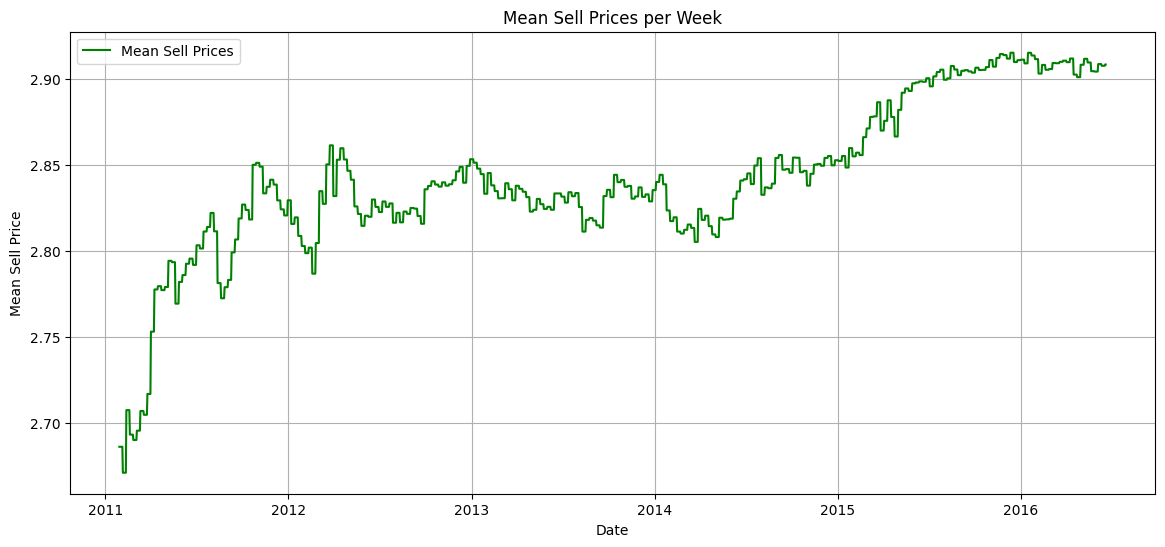

In [16]:
calendar_sell_merge = pd.merge(calendar, sell_prices, on='wm_yr_wk')

mean_prices = calendar_sell_merge.groupby('date')['sell_price'].mean()

plt.figure(figsize=(14, 6))
plt.plot(mean_prices.index, mean_prices.values, label='Mean Sell Prices', color='green')
plt.title('Mean Sell Prices per Week')
plt.xlabel('Date')
plt.ylabel('Mean Sell Price')
plt.legend()
plt.grid(True)
plt.show()

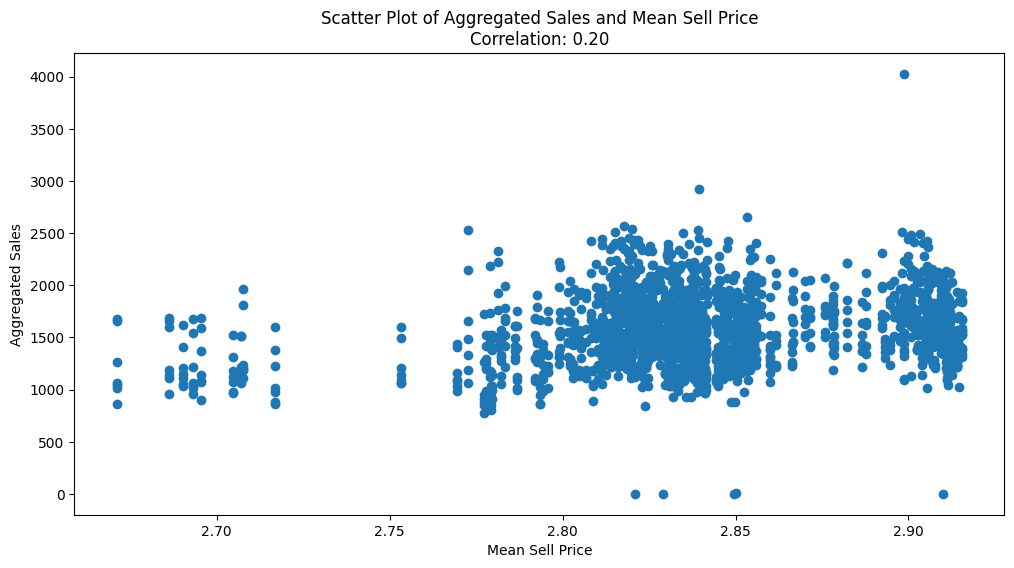

Correlation Coefficient: 0.20


In [17]:
# Merge the two DataFrames on the 'date' column
sales_sellprice_merge = pd.merge(daily_sales, mean_prices, left_on='day', right_on='date', how='inner')

# Calculate the correlation coefficient
correlation_coefficient, _ = pearsonr(sales_sellprice_merge['sales'], sales_sellprice_merge['sell_price'])

# Plotting aggregated sales
plt.figure(figsize=(12, 6))
plt.scatter(sales_sellprice_merge['sell_price'], sales_sellprice_merge['sales'])
plt.title(f'Scatter Plot of Aggregated Sales and Mean Sell Price\nCorrelation: {correlation_coefficient:.2f}')
plt.xlabel('Mean Sell Price')
plt.ylabel('Aggregated Sales')
plt.show()

# Display the correlation coefficient
print(f'Correlation Coefficient: {correlation_coefficient:.2f}')

In [18]:
events_df = calendar[['date', 'event_name_1', 'event_name_2']].dropna()

# Combine event columns into a single 'holiday' column
events_df['holiday'] = events_df['event_name_1'] + ', ' + events_df['event_name_2'].fillna('')
events_df.drop(['event_name_1', 'event_name_2'], axis=1, inplace=True)

# Convert 'date' column to datetime format
events_df['date'] = pd.to_datetime(events_df['date'])

# Filter out rows with no events
holidays_df = events_df[events_df['holiday'] != ''][['date', 'holiday']]

holidays_df.columns = ['ds', 'holiday']

In [66]:
# Prediction using the Prophet model: https://facebook.github.io/prophet/
# From our findings above we can see clear yearly and weekly seasonality.

# In this cell, a prophet model is used on every product seperately.

all_forecasts = []

# Iterate through each unique product in the dataset
for product_id in merged_data['id'].unique():
    # Filter data for the current product
    product_data = merged_data[merged_data['id'] == product_id]

    # Prepare the dataframe for Prophet
    prophet_df = product_data[['day', 'sales']].rename(columns={'day': 'ds', 'sales': 'y'})
    prophet_df['floor'] = 0

    # Instantiate Prophet model with yearly and weekly seasonality
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

    # Fit the model
    model.fit(prophet_df)

    # Create a dataframe for future dates (next 28 days)
    future = model.make_future_dataframe(periods=28)

    # Generate forecasts
    forecast = model.predict(future)

    # Round to nearest int
    forecast['yhat'] = forecast['yhat'].round()

    # Extract relevant information for the submission and reshape
    product_forecast = forecast[['ds', 'yhat']].tail(28).rename(columns={'ds': 'day', 'yhat': 'sales'})
    product_forecast['id'] = product_id

    # Pivot the dataframe to wide format
    product_forecast_wide = product_forecast.pivot(index='id', columns='day', values='sales').reset_index()
    product_forecast_wide.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

    # Append the forecast to the list
    all_forecasts.append(product_forecast_wide)

# Concatenate all individual product forecasts into a single dataframe
all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)

# Make submission file
all_forecasts_df.to_csv('submission.csv', index=False)

Streaminguitvoer ingekort tot de laatste 5000 regels.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30620', 'data', 'file=/tmp/tmpj4vrqewe/6iccit0p.json', 'init=/tmp/tmpj4vrqewe/qol2z2so.json', 'output', 'file=/tmp/tmpj4vrqewe/prophet_model33jaia4x/prophet_model-20231219123525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4vrqewe/5sed0fw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj4vrqewe/j_s8i13a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24892', 'data', 'file=/tmp/tmpj4vrqewe/5sed0fw2.json', 'init=

In [ ]:
# Merge forecasts and true values on the item_id column
merged_results = pd.merge(sales_test, all_forecasts_df, on='id', how='left')

# Extract true values and forecasted values
true_values = merged_results[['id'] + [f'd_{i}' for i in range(1914, 1942)]]
forecasted_values = merged_results[['id'] + [f'F{i}' for i in range(1, 29)]]

# Convert the DataFrames to numpy arrays
true_values_arr = true_values.drop('id', axis=1).to_numpy()
forecasted_values_arr = forecasted_values.drop('id', axis=1).to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_values_arr, forecasted_values_arr))

print(f'RMSE: {rmse}')

#RMSE without holidays: 3.3133914271517413
#RMSE with holidays: 3.313470007778738

In [19]:
# In this cell, we will use a Prophet model on aggregated sales.
# We use weekly and yearly seasonality and include our events/holidays.

# Prepare the dataframe for Prophet
prophet_df = pd.DataFrame({'ds': daily_sales.index, 'y': daily_sales.values})
prophet_df['floor'] = 0

# Instantiate Prophet model with yearly and weekly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model
model.fit(prophet_df)

# Create a dataframe for future dates (next 28 days)
future = model.make_future_dataframe(periods=28)

# Generate forecasts
forecast = model.predict(future)

# Round to nearest int
forecast['yhat'] = forecast['yhat'].round()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4paurjq7/nmkgcie4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4paurjq7/_xz5ng_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68161', 'data', 'file=/tmp/tmp4paurjq7/nmkgcie4.json', 'init=/tmp/tmp4paurjq7/_xz5ng_6.json', 'output', 'file=/tmp/tmp4paurjq7/prophet_modelfq08oahf/prophet_model-20231219145953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:59:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:59:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
#forecast['yhat']
#model.plot_components(forecast)

In [22]:
sales_test_long = pd.melt(sales_test, id_vars=['id'],
                           var_name='day', value_name='sales')
sales_test_long['day'] = pd.to_datetime('2011-01-29') + pd.to_timedelta(sales_test_long['day'].str[2:].astype(int) - 1, unit='D')
calendar['date'] = pd.to_datetime(calendar['date'])

merged_test_data = pd.merge(sales_test_long, calendar, left_on='day', right_on='date', how='left')

daily_sales_test = merged_test_data.groupby('day')['sales'].sum()

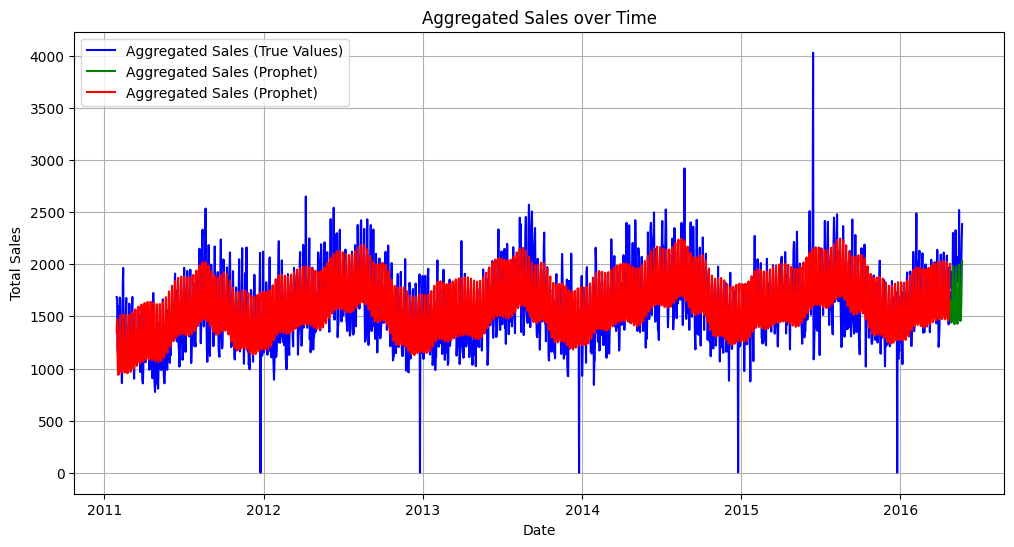

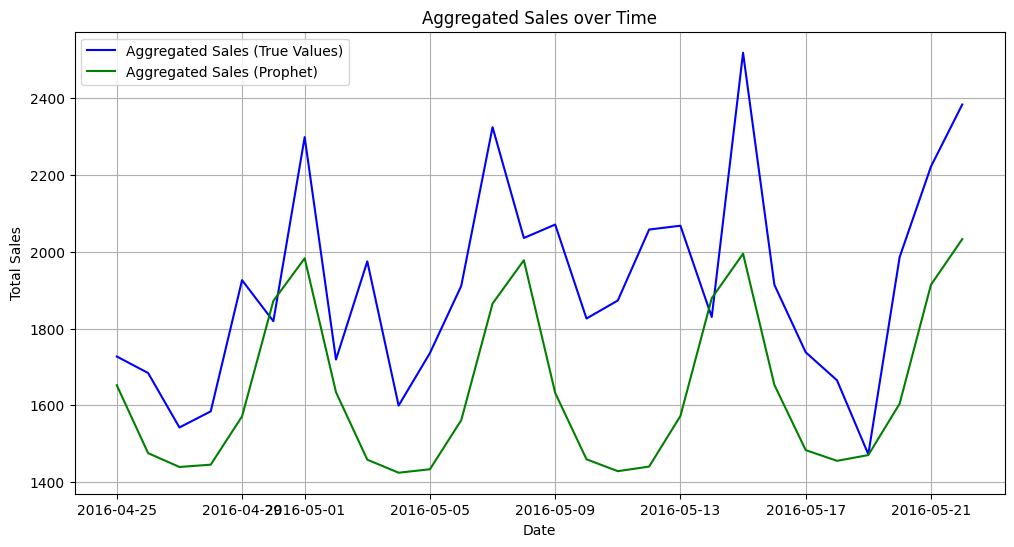

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, color='blue')
plt.plot(daily_sales_test.index, daily_sales_test.values, label='Aggregated Sales (True Values)', color='blue')
plt.plot(daily_sales_test.index, forecast['yhat'][1913:], label='Aggregated Sales (Prophet)', color='green')
plt.plot(daily_sales.index, forecast['yhat'][:1913], label='Aggregated Sales (Prophet)', color='red')
plt.title('Aggregated Sales over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales_test.index, daily_sales_test.values, label='Aggregated Sales (True Values)', color='blue')
plt.plot(daily_sales_test.index, forecast['yhat'][1913:], label='Aggregated Sales (Prophet)', color='green')
plt.title('Aggregated Sales over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
arima_df = pd.DataFrame({'ds': daily_sales.index, 'y': daily_sales.values})

autoarima_model = auto_arima(arima_df['y'], seasonal=True, trace=True)
autoarima_model.summary()
autoarima_forecast = autoarima_model.predict(n_periods=28)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27541.486, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27502.601, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27295.539, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27539.486, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26962.870, Time=0.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26878.704, Time=1.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27468.923, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26725.448, Time=1.93 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27284.444, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=26660.432, Time=2.38 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=27111.390, Time=0.56 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=26436.980, Time=2.83 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=26610.008, Time=0.49 sec
 ARIMA(5,1,2)(0,0,0)[0] i

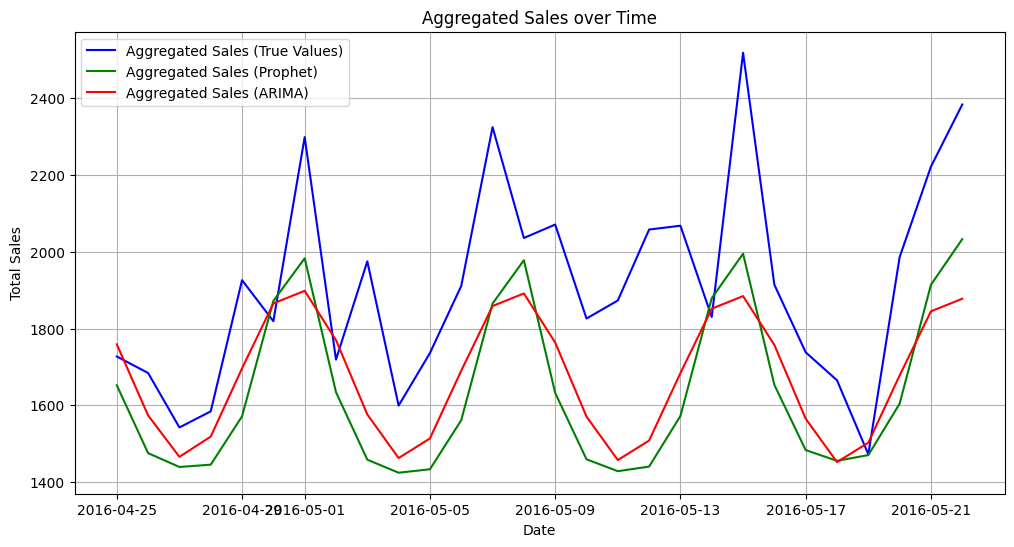

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_test.index, daily_sales_test.values, label='Aggregated Sales (True Values)', color='blue')
plt.plot(daily_sales_test.index, forecast['yhat'][1913:], label='Aggregated Sales (Prophet)', color='green')
plt.plot(daily_sales_test.index, autoarima_forecast.values, label='Aggregated Sales (ARIMA)', color='red')
plt.title('Aggregated Sales over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
!pip install tbats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 812.4 kB/s eta 0:00:00


In [39]:
# TBATS model on aggregated sales data

tbats_df = pd.DataFrame({'ds': daily_sales.index, 'y': daily_sales.values})

from tbats import TBATS
tbats_model = TBATS(seasonal_periods=(7, 365))
tbats_fit = tbats_model.fit(tbats_df['y'])
tbats_forecast = tbats_fit.forecast(steps=28)


In [57]:
# Reading model parameters
print(tbats_fit.params.alpha)
print(tbats_fit.params.beta)
print(tbats_fit.params.x0)
print(tbats_fit.params.components.use_box_cox)
print(tbats_fit.params.components.seasonal_harmonics)

0.044595427859304995
None
[1453.13230441  226.99087225   32.02485896  -15.47318983  152.0708968
   83.97666582   16.4252904  -158.0584737    33.33751965    0.
    0.            0.            0.            0.            0.        ]
False
[3 1]


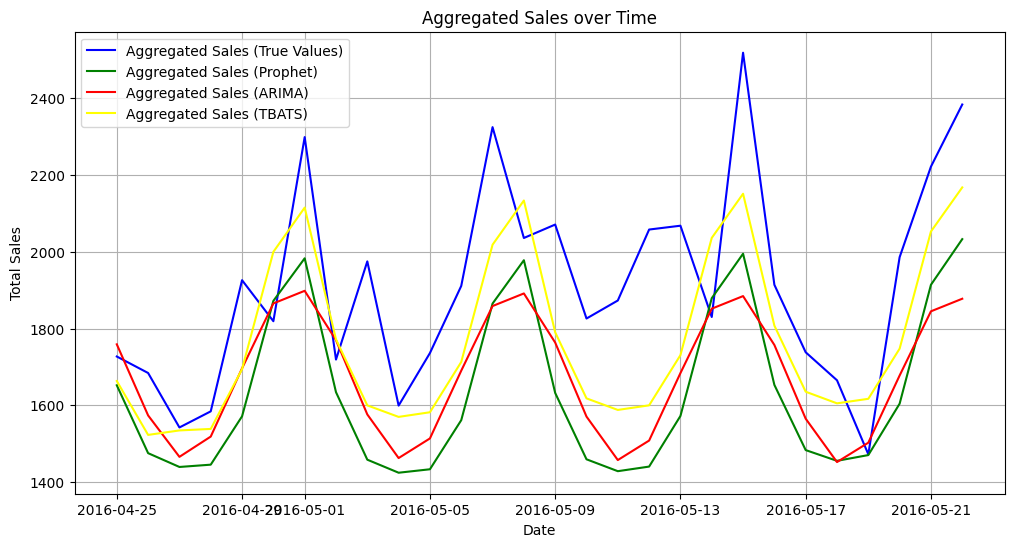

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_test.index, daily_sales_test.values, label='Aggregated Sales (True Values)', color='blue')
plt.plot(daily_sales_test.index, forecast['yhat'][1913:], label='Aggregated Sales (Prophet)', color='green')
plt.plot(daily_sales_test.index, autoarima_forecast.values, label='Aggregated Sales (ARIMA)', color='red')
plt.plot(daily_sales_test.index, tbats_forecast, label='Aggregated Sales (TBATS)', color='yellow')
plt.title('Aggregated Sales over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

In [63]:
# Get mean distribution of sales for each product

merged_data['total_sales'] = merged_data.groupby('day')['sales'].transform('sum')
merged_data['percentage_sales'] = (merged_data['sales'] / merged_data['total_sales'])
mean_percentage_by_product = merged_data.groupby('id')['percentage_sales'].mean().reset_index()
print(mean_percentage_by_product)

                              id  percentage_sales
0    FOODS_3_001_TX_3_validation          0.000222
1    FOODS_3_002_TX_3_validation          0.000451
2    FOODS_3_003_TX_3_validation          0.000071
3    FOODS_3_004_TX_3_validation          0.000052
4    FOODS_3_005_TX_3_validation          0.000493
..                           ...               ...
818  FOODS_3_823_TX_3_validation          0.000134
819  FOODS_3_824_TX_3_validation          0.000147
820  FOODS_3_825_TX_3_validation          0.000394
821  FOODS_3_826_TX_3_validation          0.000371
822  FOODS_3_827_TX_3_validation          0.000219

[823 rows x 2 columns]


In [89]:
estimated_sales = (mean_percentage_by_product['percentage_sales'][:, np.newaxis] * tbats_forecast).round()

#print(sales_test.iloc[:, 1:])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sales_test.iloc[:, 1:], estimated_sales))

print(f'RMSE: {rmse}')

RMSE: 3.601511042792409


<ipython-input-89-0ff6cd2fb411>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  estimated_sales = (mean_percentage_by_product['percentage_sales'][:, np.newaxis] * tbats_forecast).round()
